# Remove nan stations
- Remove Station 62 and 74 in data.py, use this to check
- CDF Plots from graph_creation.ipynb
- compute dist2 and dist3 beforehand for all leadtimes as they depend on the leadtimes

In [1]:
%cd /home/ltchen/gnnpp
import sys
import json
import os
from scipy.interpolate import interp1d
from utils.data import *
from torch_geometric.utils import is_undirected, degree, contains_isolated_nodes
from tqdm import tqdm
import xarray as xr
import wandb
from exploration.graph_creation import *
from torch_geometric.loader import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.optim import AdamW
from pytorch_lightning.loggers import WandbLogger
from exploration.graph_creation import *
import matplotlib.pyplot as plt

/home/ltchen/gnnpp


In [3]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
leadtime = "72h"
DIRECTORY = os.getcwd()
FIGUREPATH = os.path.join(DIRECTORY, 'figures')
os.makedirs(FIGUREPATH, exist_ok=True)
SAVEPATH = os.path.join(DIRECTORY, f"explored_models/gnn_no_ensemble_{leadtime}/models")
JSONPATH = os.path.join(DIRECTORY, f"trained_models/best_{leadtime}/params.json")

In [4]:
dataframes = load_dataframes(leadtime= leadtime)
dataframes = summary_statistics(dataframes)

[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Calculating summary statistics for train
[INFO] Calculating summary statistics for valid
[INFO] Calculating summary statistics for test_rf
[INFO] Calculating summary statistics for test_f


In [5]:
dataframes['stations'].shape

(120, 6)

In [6]:
dataframes['train'][0].shape

(313440, 65)

### Distance metrics 2 & 3

In [7]:
graphs = create_graph_dataset(
        df_train=dataframes['train'][0],
        df_target=dataframes['train'][1],
        station_df=dataframes['stations'],
        attributes=["dist2", "dist3"], # , "dist3"
        edges=[("dist2", 0.003), ("dist3", 0.0073)], # , "dist3"
        sum_stats = True,
        leadtime = "120h",)
graphs

AssertionError: train_set should not be none.

In [7]:
matd2 = compute_mat(dataframes['stations'], mode="dist2", sum_stats= True, train_set= dataframes['train'][0], train_target_set = dataframes['train'][1], leadtime = "120h")
matd2.shape

[INFO] Loading distances from file...


(120, 120)

In [10]:
d2mat = load_d2_distances(dataframes['stations'], dataframes['train'][0], sum_stats=True, leadtime="24h")

[INFO] Loading distances from file...


In [12]:
d2mat.max()

0.2601907281080329

In [11]:
d3mat = load_d3_distances(dataframes['stations'], dataframes['train'][0], dataframes['train'][1], sum_stats=True, leadtime="24h")

[INFO] Loading distances from file...


In [13]:
d3mat.max()

0.5731814701378253

In [8]:
dataframes = load_dataframes(leadtime="24h")
dataframes = summary_statistics(dataframes)
d3mat_24h = load_d3_distances(dataframes['stations'], dataframes['train'][0], dataframes['train'][1], sum_stats=True, leadtime="72h")

[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Calculating summary statistics for train
[INFO] Calculating summary statistics for valid
[INFO] Calculating summary statistics for test_rf
[INFO] Calculating summary statistics for test_f
[INFO] Loading distances from file...


In [7]:
d3mat_24h

array([[0.        , 0.06586907, 0.01095904, ..., 0.33626531, 0.28579632,
        0.31267228],
       [0.06586907, 0.        , 0.07433959, ..., 0.27041539, 0.2202144 ,
        0.24827718],
       [0.01095904, 0.07433959, 0.        , ..., 0.34471669, 0.29394142,
        0.31930513],
       ...,
       [0.33626531, 0.27041539, 0.34471669, ..., 0.        , 0.05077527,
        0.02541156],
       [0.28579632, 0.2202144 , 0.29394142, ..., 0.05077527, 0.        ,
        0.03049387],
       [0.31267228, 0.24827718, 0.31930513, ..., 0.02541156, 0.03049387,
        0.        ]])

In [16]:
np.unravel_index(np.argmax(d2mat), d2mat.shape)

(2, 119)

In [26]:
dataframes['train'][0]['t2m_mean'].min()

245.61275

In [17]:
dataframes['train'][0]['t2m_mean'].max()
percentile99 = (dataframes['train'][0]['t2m_mean'].max() - dataframes['train'][0]['t2m_mean'].min())*0.99 + dataframes['train'][0]['t2m_mean'].min()
step_size = (dataframes['train'][0]['t2m_mean'].max() - dataframes['train'][0]['t2m_mean'].min())/50
percentile99
#step_size


299.1410725402832

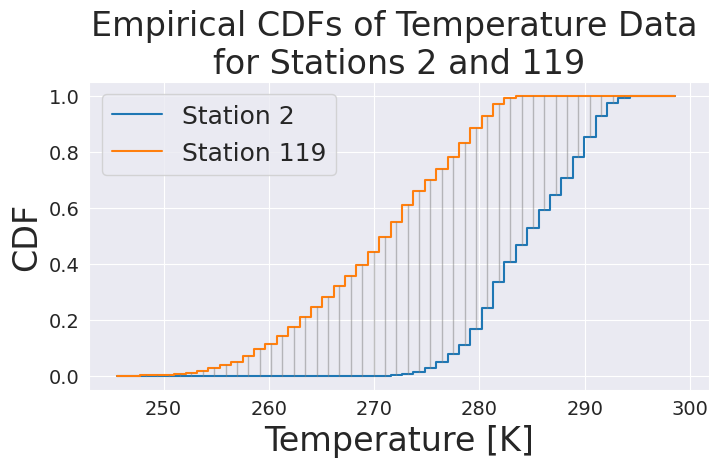

In [31]:
# check if get_emp_cdf works
i = 2
j = 119
S = np.arange(dataframes['train'][0]['t2m_mean'].min(),percentile99, step_size) #1th and 99th percentile? => Anzahl Schritte statt Schritgroesse? => equidistant
#cdf_values = create_emp_cdf(train_set['t2m'])(S)
temps1 = dataframes['train'][0][dataframes['train'][0]['station_id'] == i]['t2m_mean']
temps2 = dataframes['train'][0][dataframes['train'][0]['station_id'] == j]['t2m_mean']
cdf1 = create_emp_cdf(temps1)(S)
cdf2 = create_emp_cdf(temps2)(S)
#print(cdf1.shape)

plt.figure(figsize=(8, 4))
plt.step(S, cdf1, where='post', label=f'Station {i}')
plt.step(S, cdf2, where='post', label=f'Station {j}')
for x, y1, y2 in zip(S, cdf1, cdf2):
    plt.plot([(x+0.5*step_size), (x+0.5*step_size)], [y1, y2], color='gray', alpha=0.5, linewidth=1)
plt.title(f'Empirical CDFs of Temperature Data \nfor Stations {i} and {j}', fontsize=24)
plt.xlabel('Temperature [K]', fontsize=24)
plt.ylabel('CDF', fontsize=24)
plt.grid(True)
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGUREPATH, "methodology/dist2_big.pdf"), bbox_inches = 'tight', dpi=300)
plt.show()


In [ ]:
plt.figure(figsize=(8, 4))
plt.step(S_d2.T, list_of_all_G2_i_values[117], where='post', label='Empirical CDF')
plt.title('Empirical CDF of Forecast Errors')
plt.xlabel('Error')
plt.ylabel('CDF')
plt.grid(True)
plt.show()

In [35]:
# check if get_emp_cdf works
S_d3 = np.arange(-10, 10, 0.5)
cdfs = []

for i_id in range(0, dataframes['stations'].station_id.nunique()):
    i_train = dataframes['train'][0][dataframes['train'][0]['station_id'] == i_id]
    i_target_temps = dataframes['train'][1][dataframes['train'][1]['station_id'] == i_id]['t2m']
    G_s = create_emp_cdf_of_errors(i_train, i_target_temps, True)
    cdfs.append(G_s)
list_of_all_G_i_values = []
for G_i in tqdm(cdfs):
    cdf_values = np.zeros(S.shape)
    for idx, x in enumerate(S):
        cdf_values[idx] = G_i(x)
    # print(cdf_values)
    list_of_all_G_i_values.append(cdf_values)
    # print(len(list_of_all_G_i_values))


print(all(f is cdfs[0] for f in cdfs))

100%|██████████| 120/120 [00:50<00:00,  2.35it/s]

False


In [37]:
print(list_of_all_G_i_values[63])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]


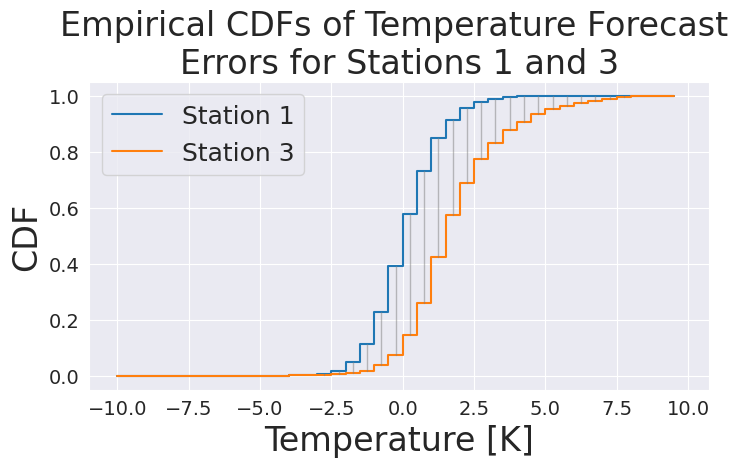

In [33]:
# plot
# check if create_emp_cdf_of_errors(station_df, target_temp, sum_stats)
i = 1
j = 3
# S = np.arange(dataframes['train'][0]['t2m_mean'].min(), dataframes['train'][0]['t2m_mean'].max(), 1) #1th and 99th percentile? => Anzahl Schritte statt Schritgroesse? => equidistant
S_d3 = np.arange(-10, 10, 0.5)
#cdf_values = create_emp_cdf(train_set['t2m'])(S)
#temps1 = dataframes['train'][0][dataframes['train'][0]['station_id'] == i]['t2m_mean']
#temps2 = dataframes['train'][0][dataframes['train'][0]['station_id'] == j]['t2m_mean']
i_train = dataframes['train'][0][dataframes['train'][0]['station_id'] == i]
i_target_temps = dataframes['train'][1][dataframes['train'][1]['station_id'] == i]['t2m']
j_train = dataframes['train'][0][dataframes['train'][0]['station_id'] == j]
j_target_temps = dataframes['train'][1][dataframes['train'][1]['station_id'] == j]['t2m']
list_for_cdf1 = []
list_for_cdf2 = []
for z in S_d3:
    cdf1 = create_emp_cdf_of_errors(station_df=i_train, target_temp=i_target_temps, sum_stats=True)(z)
    cdf2 = create_emp_cdf_of_errors(station_df=j_train, target_temp=j_target_temps, sum_stats=True)(z)
    list_for_cdf1.append(cdf1)
    list_for_cdf2.append(cdf2)

#print(cdf1.shape)

plt.figure(figsize=(8, 4))
plt.step(S_d3, list_for_cdf1, where='post', label=f'Station {i}')
plt.step(S_d3, list_for_cdf2, where='post', label=f'Station {j}')
for x, y1, y2 in zip(S_d3, list_for_cdf1, list_for_cdf2):
    plt.plot([(x+0.25), (x+0.25)], [y1, y2], color='gray', alpha=0.5, linewidth=1)
plt.title(f'Empirical CDFs of Temperature Forecast \nErrors for Stations {i} and {j}', fontsize=24)
plt.xlabel('Temperature [K]', fontsize=24)
plt.ylabel('CDF', fontsize=24)
plt.grid(True)
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGUREPATH, "methodology/dist3_small.pdf"), bbox_inches = 'tight', dpi=300)
plt.show()


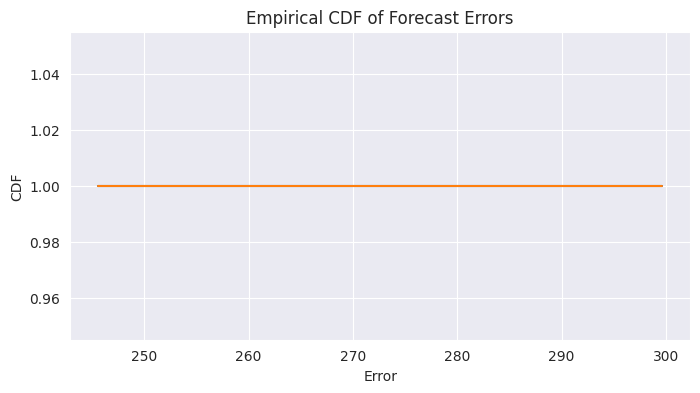

In [33]:
# print(list_of_all_G_i_values[63])
i = 1
j = 3
plt.figure(figsize=(8, 4))
plt.step(S.T, list_of_all_G_i_values[1], where='post', label=f'Error CDF Station {i}')
plt.step(S.T, list_of_all_G_i_values[j], where='post', label=f'Error CDF Station {j}')
plt.title('Empirical CDF of Forecast Errors')
plt.xlabel('Error')
plt.ylabel('CDF')
plt.grid(True)
plt.show()

In [42]:
for idx, array in enumerate(list_of_all_G_i_values):
    if np.all(array == 0):
        print(idx)

### Load graphs

In [31]:
leadtime = "24h"

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
DIRECTORY = os.getcwd()
SAVEPATH = os.path.join(DIRECTORY, f"leas_final_models/gnn_run5_{leadtime}/models")
JSONPATH = os.path.join(DIRECTORY, f"trained_models/best_{leadtime}/params.json")

with open(JSONPATH, "r") as f:
    print(f"[INFO] Loading {JSONPATH}")
    args_dict = json.load(f)
config = args_dict

'''{"batch_size":8,
"gnn_hidden":265,
"gnn_layers":2,
"heads":8,
"lr":0.0002,
"max_dist":100,
"max_epochs": 31}'''

[INFO] Loading /home/ltchen/gnnpp/trained_models/best_24h/params.json


In [32]:
graph_name = "g1"
graphs1_train_rf, tests1 = normalize_features_and_create_graphs1(df_train=dataframes['train'], df_valid_test=[dataframes['valid'], dataframes['test_rf'], dataframes['test_f']], station_df=dataframes['stations'], attributes=["geo"], edges=[("geo", 100)], sum_stats = True)
graphs1_valid_rf, graphs1_test_rf, graphs1_test_f = tests1

g1_train_loader = DataLoader(graphs1_train_rf, batch_size=config['batch_size'], shuffle=True)
g1_valid_loader = DataLoader(graphs1_valid_rf, batch_size=config['batch_size'], shuffle=False)
g1_test_f_loader = DataLoader(graphs1_test_f, batch_size=config['batch_size'], shuffle=False)
g1_test_rf_loader = DataLoader(graphs1_test_rf, batch_size=config['batch_size'], shuffle=False)

train_loader = g1_train_loader
valid_loader = g1_valid_loader
test_f_loader = g1_test_f_loader
test_rf_loader = g1_test_rf_loader
test_loader = [test_f_loader, test_rf_loader]

emb_dim = 20
in_channels = graphs1_train_rf[0].x.shape[1] + emb_dim - 1
edge_dim = graphs1_train_rf[0].num_edge_features
num_nodes = graphs1_train_rf[0].num_nodes
# max_epochs = max_epoch_list[graph_name]
max_epochs = 31



[INFO] Normalizing features...
fit_transform
transform 1
transform 2
transform 3


100%|██████████| 730/730 [00:02<00:00, 279.82it/s]


In [55]:
graphs1_train_rf[0].num_idx

AttributeError: 'GlobalStorage' object has no attribute 'num_idx'

In [98]:
PROJECTNAME = "gnn_run_test"
graph_name = "g1"
FILENAME = graph_name + "_run_" + leadtime
TRAINNAME = graph_name + "_train_run_" + leadtime

RESULTPATH = os.path.join(DIRECTORY, f"leas_trained_models/best_{leadtime}/best_{leadtime}_{graph_name}")

with wandb.init(
        project=PROJECTNAME, id=TRAINNAME, config=args_dict, tags=["final"]
):
    config = wandb.config

    multigraph = Multigraph1(
        num_nodes=num_nodes, #120
        embedding_dim=emb_dim, #20
        edge_dim=edge_dim, # 1
        in_channels=in_channels, # 84
        hidden_channels_gnn=config['gnn_hidden'], # 265
        out_channels_gnn=config['gnn_hidden'], # 265
        num_layers_gnn=config['gnn_layers'], # 2
        heads=config['heads'], # 8
        hidden_channels_deepset=config['gnn_hidden'], # 265
        optimizer_class=AdamW,
        optimizer_params=dict(lr=config['lr']),
    )
    torch.compile(multigraph)
    batch = next(iter(train_loader))
    multigraph.forward(batch)

    wandb_logger = WandbLogger(project=PROJECTNAME)
    checkpoint_callback = ModelCheckpoint(
        dirpath=SAVEPATH, filename=TRAINNAME, monitor="train_loss", mode="min", save_top_k=1
    )

    # print("[INFO] Training model...")
    trainer = L.Trainer(
        max_epochs=max_epochs,
        log_every_n_steps=1,
        accelerator="gpu",
        devices=1,
        enable_progress_bar=True,
        logger=wandb_logger,
        callbacks=checkpoint_callback,
    )

    trainer.fit(model=multigraph, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | encoder     | EmbedStations     | 2.4 K  | train
1 | conv        | ResGnn            | 9.9 M  | train
2 | aggr        | DeepSetAggregator | 212 K  | train
3 | postprocess | MakePositive      | 0      | train
4 | loss_fn     | Norm

Epoch 0:  52%|█████▏    | 171/327 [00:05<00:04, 32.43it/s, v_num=_24h, train_loss_step=1.070]


Detected KeyboardInterrupt, attempting graceful shutdown ...
Traceback (most recent call last):
  File "/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py", line 47, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
  File "/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 574, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 981, in _run
    results = self._run_stage()
  File "/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 1025, in _run_stage
    self.fit_loop.run()
  File "/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py", line 205, in run
    self.advance()
  File "/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,▆▇█▆▄▃▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████
epoch,0
train_loss_step,1.07425
trainer/global_step,170


NameError: name 'exit' is not defined

In [44]:
print(6840/8)

855.0


In [11]:
graphs_valid_rf, graphs_test_rf, graphs_test_f = valid_tests

In [21]:
graphs_valid_rf[0].y.shape

torch.Size([120])

In [9]:
dataframes['test_rf'][1][dataframes['test_rf'][1]['station_id'] == 63]

,time,station_id,t2m
63,2014-01-01,63,272.05
183,2014-01-02,63,271.25
303,2014-01-04,63,273.65
423,2014-01-05,63,272.05
543,2014-01-08,63,272.95
...,...,...,...
87303,2017-12-17,63,267.35
87423,2017-12-20,63,272.15
87543,2017-12-24,63,273.35
87663,2017-12-27,63,273.85


### Check station nans
Station_id was wrong so had to adjust data.py file to map the right station_id

In [ ]:
ZARRDATAFOLDER = '/mnt/sda/Data2/gnnpp-data/EUPPBench-stations/'
xr_train = xr.open_zarr(f'{ZARRDATAFOLDER}train.zarr')
xr_train = xr_train.sel(step="24h").drop_vars(["step"])
xr_train = xr_train.drop_vars(
    ["model_altitude", "model_land_usage", "model_latitude", "model_longitude", "station_land_usage"]
)
df_train = (
    xr_train.to_dataframe()
    .reorder_levels(["time", "number", "station_id"])
    .sort_index(level=["time", "number", "station_id"])
    .reset_index()
)

station_ids = df_train.station_id.unique()
id_to_index = {station_id: i for i, station_id in enumerate(station_ids)}

df_train["station_id"] = df_train["station_id"].apply(lambda x: id_to_index[x])

In [ ]:
df_train

In [ ]:
# check station_df
def get_stations(arr: xr.Dataset) -> pd.DataFrame:
    """
    Get the stations information from the dataset.

    Args:
        arr (xarray.Dataset): The dataset containing station information.

    Returns:
        pd.DataFrame: The dataframe containing station information.
    """
    stations = pd.DataFrame(
        {
            "station_id": arr.station_id.values,
            "lat": arr.station_latitude.values,
            "lon": arr.station_longitude.values,
            "altitude": arr.station_altitude.values,
            "orog": arr.model_orography.values,
            "name": arr.station_name.values,
        }
    )

    stations = stations.sort_values("station_id").reset_index(drop=True)
    print("test")
    return stations

In [ ]:
ZARRDATAFOLDER = '/mnt/sda/Data2/gnnpp-data/EUPPBench-stations/'
xr_train = xr.open_zarr(f'{ZARRDATAFOLDER}train.zarr')
stations_train = get_stations(xr_train)
stations_train['station_id'] = stations_train['station_id'].apply(lambda x: id_to_index[x])

xr_forecasts = xr.open_zarr(f'{ZARRDATAFOLDER}test_f.zarr')
stations_f = get_stations(xr_forecasts)
stations_f['station_id'] = stations_f['station_id'].apply(lambda x: id_to_index[x])

In [ ]:
# test1 = (stations_f.station_id == stations_rf.station_id).all()
# test2 = (stations_train.station_id == stations_rf.station_id).all()
test3 = (stations_f.station_id == stations_train.station_id).all()
test3

In [ ]:
dataframes['stations'] = dataframes['stations'][~dataframes['stations']['station_id'].isin([64, 72])]
# dataframes['stations'].station_id.nunique()
# dataframes['train']
dataframes['test_rf'][0].station_id.unique()
# dataframes['test_rf']
# dataframes['test_f']
# dataframes['stations']